### 1. Import Packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, RepeatedKFold #, LeaveOneOut
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer

from statistics import stdev, variance
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score

import seaborn
import matplotlib.pyplot as plt

### 2. Import data and data cleaning

#### 2.1 Data description

In [2]:
indat = pd.read_csv(r'/Users/lizhuheng/Downloads/diabetes2.csv')
indat = indat.drop(['Unnamed: 0'], axis = 1)
print("The shape of the data is {}".format(indat.shape))
indat.loc[indat['diabetes'] == 'pos', 'Outcome'] = 1
indat.loc[indat['diabetes'] == 'neg', 'Outcome'] = 0
indat = indat.drop(['diabetes'], axis = 1)
indat['Outcome'] = indat['Outcome'].astype('category')
indat.head(5)

The shape of the data is (768, 9)


,pregnant,glucose,pressure,triceps,insulin,mass,pedigree,age,Outcome
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1.0
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0.0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1.0
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0.0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1.0


In [3]:
indat.isnull().sum() 

pregnant      0
glucose       5
pressure     35
triceps     227
insulin     374
mass         11
pedigree      0
age           0
Outcome       0
dtype: int64

#### Describe each feature
**$N, mean, std, min, Q_1, median, Q_3, max$ were output.**

In [4]:
indat.describe()

,pregnant,glucose,pressure,triceps,insulin,mass,pedigree,age
count,768.000000,763.000000,733.000000,541.000000,394.000000,757.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,155.548223,32.457464,0.471876,33.240885
std,3.369578,30.535641,12.382158,10.476982,118.775855,6.924988,0.331329,11.760232
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000
25%,1.000000,99.000000,64.000000,22.000000,76.250000,27.500000,0.243750,24.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000
75%,6.000000,141.000000,80.000000,36.000000,190.000000,36.600000,0.626250,41.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000


**Get unique values for each feature - to determine whether the feaure is continuous or categorical.**

In [5]:
indat.nunique(axis=0)

pregnant     17
glucose     135
pressure     46
triceps      50
insulin     185
mass        247
pedigree    517
age          52
Outcome       2
dtype: int64

**Check missing values.**

In [6]:
indat_miss = indat.dropna()
print("The shape of the data after removing missing values is {}".format(indat_miss.shape))

The shape of the data after removing missing values is (392, 9)


**Pairwise scatter plots for different features, histgram for the feature itself.**

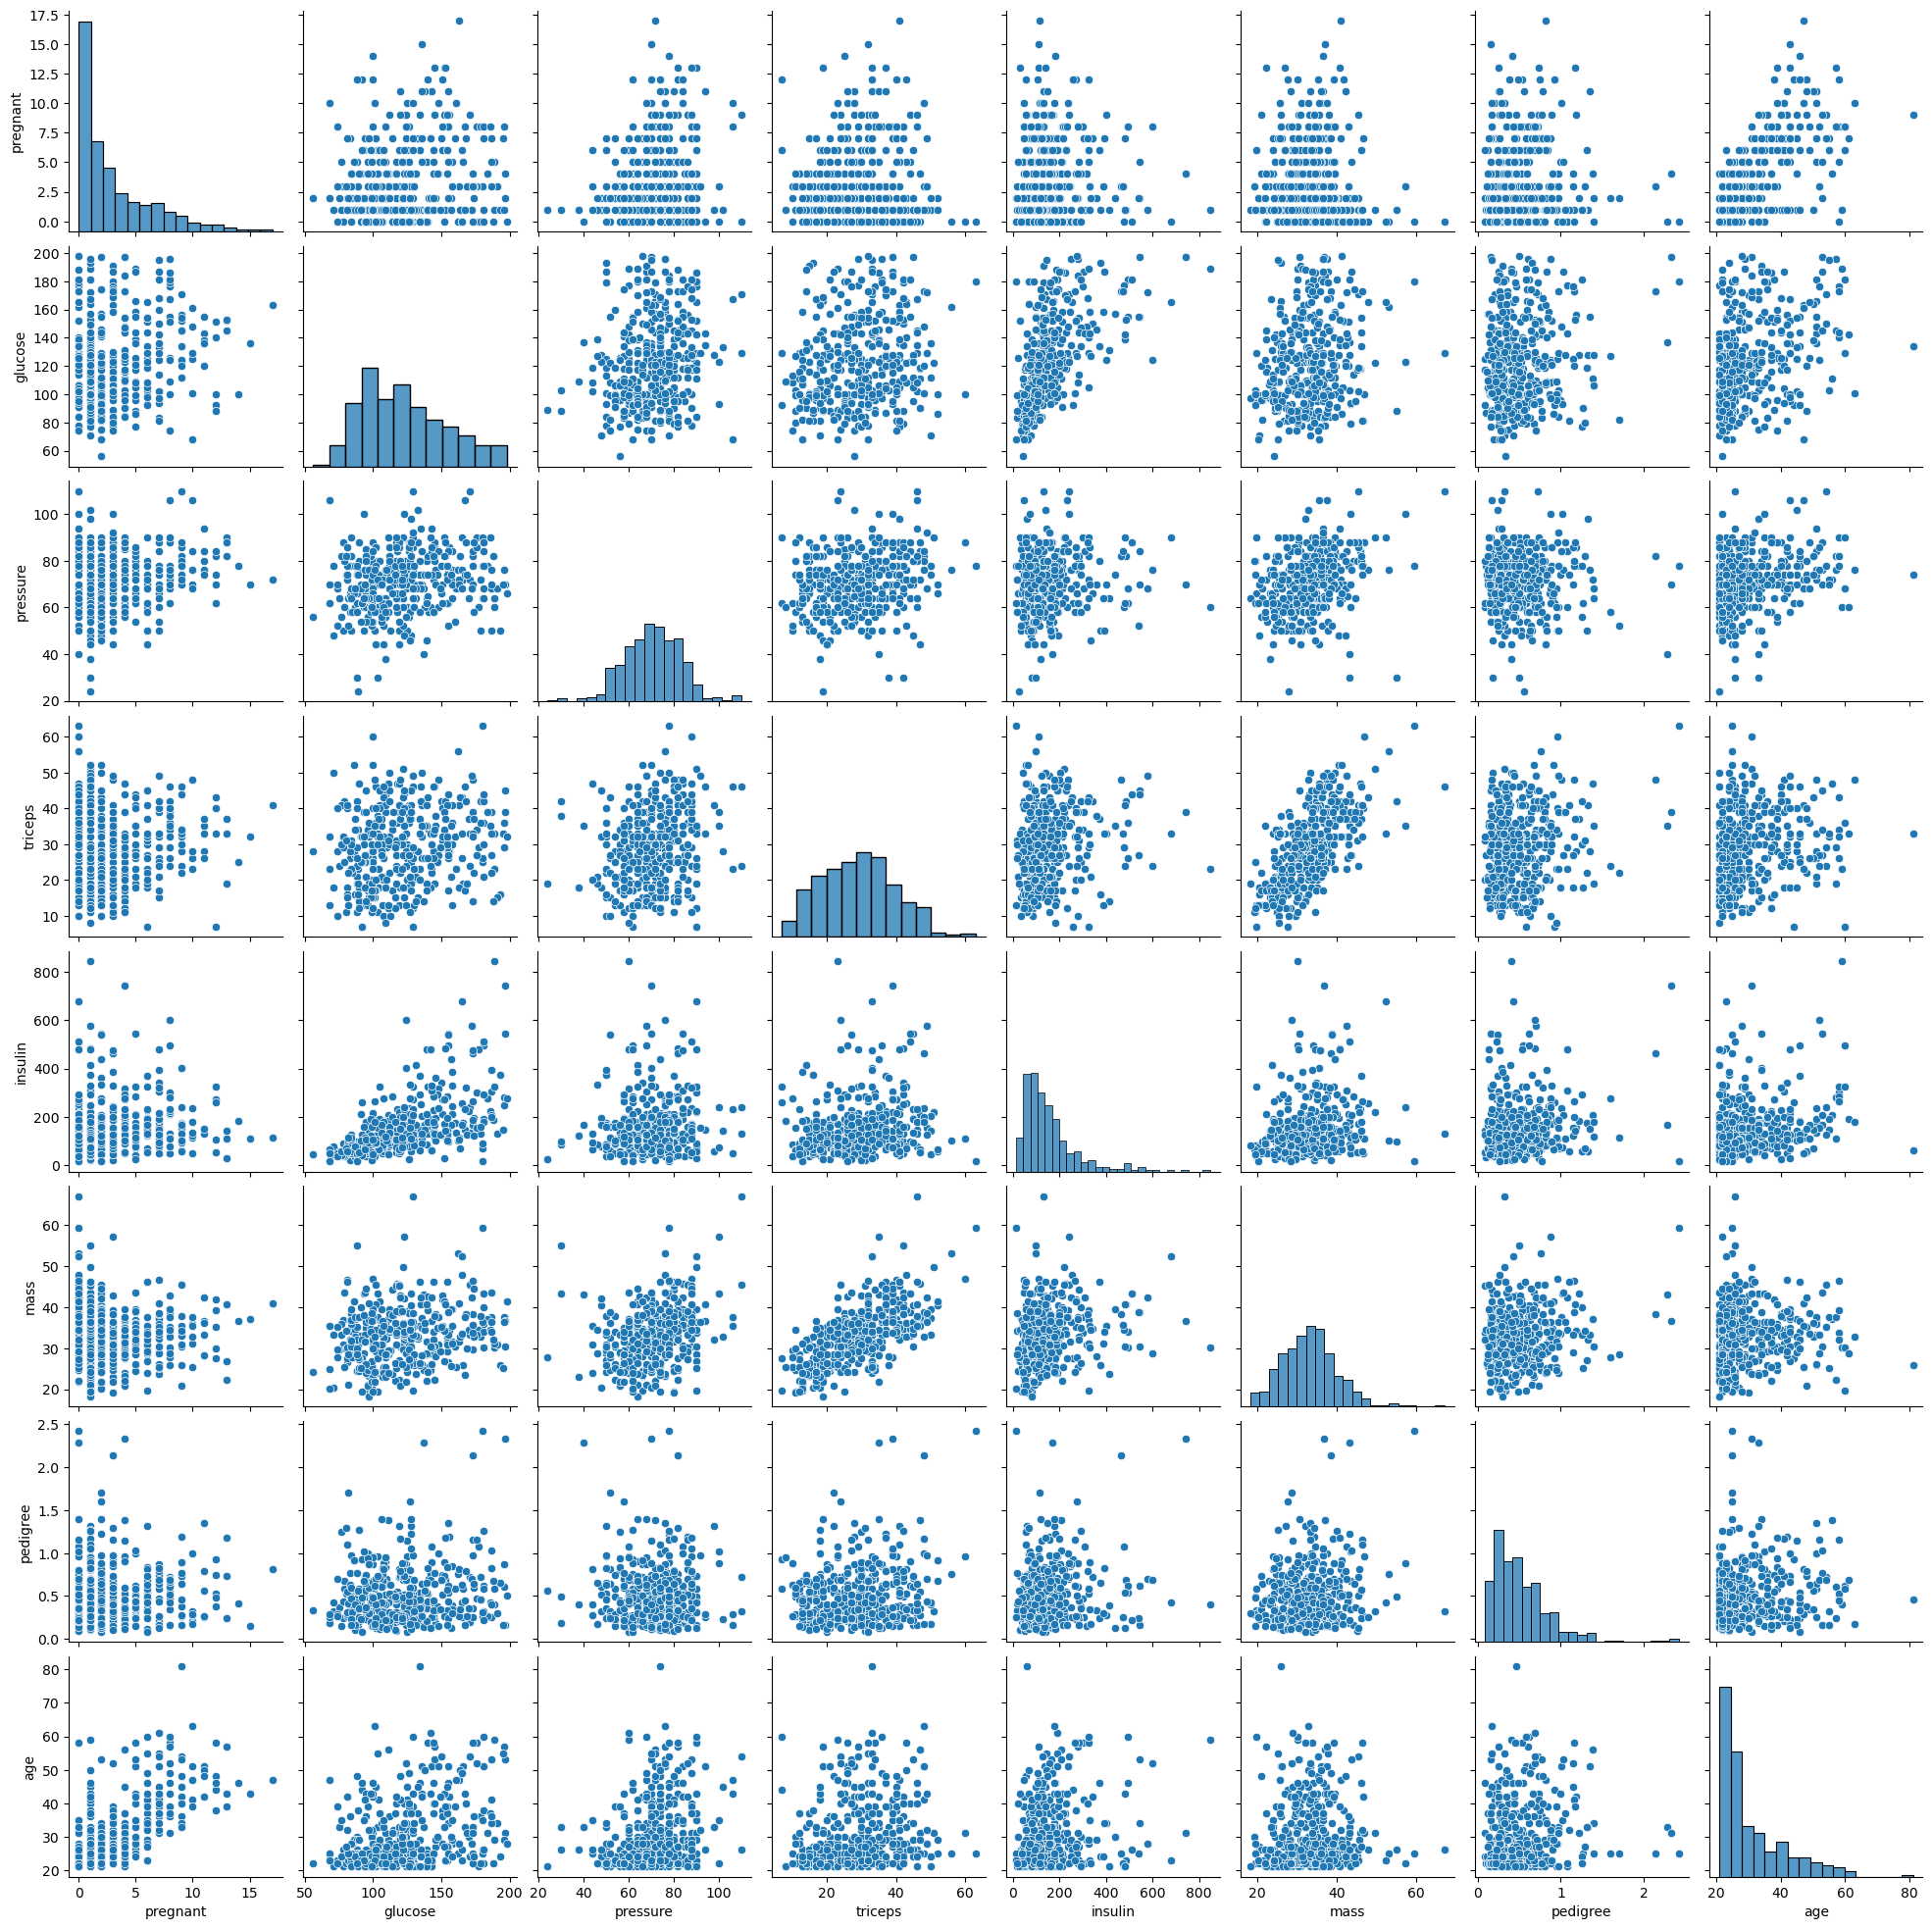

In [7]:
seaborn.pairplot(indat_miss.drop(['Outcome'], axis = 1))
plt.show()

**Heatmap plot: pairwise correlation for all features.**

<Axes: >

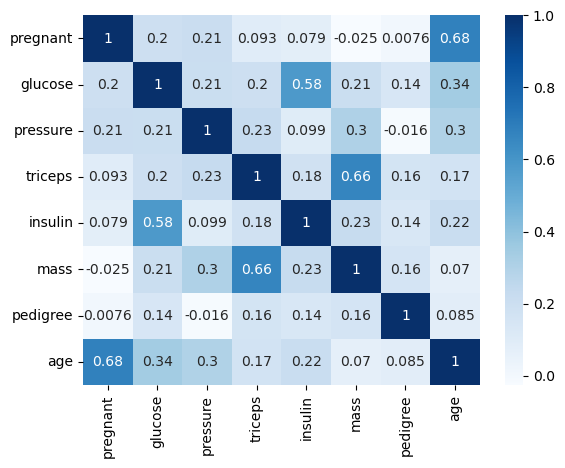

In [8]:
corr = indat_miss.drop(['Outcome'], axis = 1).corr()
seaborn.heatmap(corr, cmap="Blues", annot=True, xticklabels=corr.columns, yticklabels=corr.columns)

#### 2.2 train_test_split before missing value imputation - 70% vs. 30%

In [9]:
X = indat.drop(['Outcome'], axis = 1)
y = indat['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape)
print(X_test.shape)
X_train.head(10)

(537, 8)
(231, 8)


,pregnant,glucose,pressure,triceps,insulin,mass,pedigree,age
334,1,95.0,60.0,18.0,58.0,23.9,0.260,22
139,5,105.0,72.0,29.0,325.0,36.9,0.159,28
485,0,135.0,68.0,42.0,250.0,42.3,0.365,24
547,4,131.0,68.0,21.0,166.0,33.1,0.160,28
18,1,103.0,30.0,38.0,83.0,43.3,0.183,33
593,2,82.0,52.0,22.0,115.0,28.5,1.699,25
140,3,128.0,78.0,NaN,NaN,21.1,0.268,55
326,1,122.0,64.0,32.0,156.0,35.1,0.692,30
266,0,138.0,NaN,NaN,NaN,36.3,0.933,25
626,0,125.0,68.0,NaN,NaN,24.7,0.206,21


#### 2.3 Missing value imputation

**There are 376 (49%) patients with one or more missing values, so we need to impute missing values before modeling step.**

In [10]:
imputer = KNNImputer(n_neighbors=5)
X_train_knn = pd.DataFrame(imputer.fit_transform(X_train), columns = X_train.columns)
print("The shape of the data KNN missing value imputation of training set is {}".format(X_train_knn.shape))
X_test_knn = pd.DataFrame(imputer.transform(X_test), columns = X_test.columns)
print("The shape of the data KNN missing value imputation of testing set is {}".format(X_test.shape))

X_train_knn = X_train_knn.dropna()
print("Check missing values and the shape after KNN missing value imputation for training set is {}".format(X_train_knn.shape))
X_test_knn = X_test_knn.dropna()
print("Check missing values and the shape after KNN missing value imputation for testing set is {}".format(X_test_knn.shape))

The shape of the data KNN missing value imputation of training set is (537, 8)
The shape of the data KNN missing value imputation of testing set is (231, 8)
Check missing values and the shape after KNN missing value imputation for training set is (537, 8)
Check missing values and the shape after KNN missing value imputation for testing set is (231, 8)


### 3. Data pre-processing - centering and scaling

#### 3.0 Standardization
$$\frac{X-\mu}{\sigma}$$

In [11]:
def scale_X(train, test):
    scaler = StandardScaler()
    train_scaled = train.copy()
    train_num = train_scaled
    col_names = train_num.columns
    train_scaled[col_names] = scaler.fit_transform(train_num.values)
    
      
    test_scaled = test.copy()
    test_num = test_scaled
    col_names1 = test_num.columns
    test_scaled[col_names1] = scaler.transform(test_num.values)
    
    return train_scaled, test_scaled

X_train_scaled, X_test_scaled = scale_X(X_train_knn, X_test_knn)
print(X_train_scaled.head(5))
X_test_scaled.head(5)

   pregnant   glucose  pressure   triceps   insulin      mass  pedigree  \
0 -0.836294 -0.892298 -0.989259 -1.191302 -0.964254 -1.200342 -0.614216   
1  0.390728 -0.560706 -0.011621  0.035130  1.775690  0.665570 -0.909738   
2 -1.143050  0.434071 -0.337500  1.484549  1.006043  1.440641 -0.306991   
3  0.083972  0.301434 -0.337500 -0.856820  0.144038  0.120150 -0.906812   
4 -0.836294 -0.627024 -3.433352  1.038574 -0.707705  1.584173 -0.839515   

        age  
0 -0.948610  
1 -0.434667  
2 -0.777296  
3 -0.434667  
4 -0.006380  


,pregnant,glucose,pressure,triceps,insulin,mass,pedigree,age
0,0.697483,-0.792821,-1.152198,0.481105,0.390325,0.249328,-0.116804,0.850192
1,-0.529539,-0.328591,0.232788,0.369611,-0.282859,0.493332,-0.941923,-1.034268
2,-0.529539,-0.461228,-0.663379,-0.187858,-0.120720,-0.209973,-0.912664,-1.034268
3,1.310994,-0.494388,0.640137,-0.544638,-0.403951,-1.099870,1.129653,0.079277
4,1.004239,0.467230,1.454835,-0.009468,0.837747,-0.339152,-0.760514,1.449793


In [12]:
# y_train1 = pd.DataFrame(y_train, columns = ['Outcome'])
# y_test1 = pd.DataFrame(y_test, columns = ['Outcome'])

# X_train_scaled['y'] = y_train1['Outcome'].values
# X_test_scaled['y'] = y_test1['Outcome'].values
# print(X_train_scaled.head(5))
# X_test_scaled.head(5)


# X_train_knn['y'] = y_train1['Outcome'].values
# X_test_knn['y'] = y_test1['Outcome'].values
# print(X_train_knn.head(5))
# X_test_knn.head(5)

In [13]:
# X_train_scaled.to_csv('/Users/lizhuheng/Downloads/train.csv')
# X_test_scaled.to_csv('/Users/lizhuheng/Downloads/test.csv')

# X_train_knn.to_csv('/Users/lizhuheng/Downloads/train2.csv')
# X_test_knn.to_csv('/Users/lizhuheng/Downloads/test2.csv')

### 4. Modeling

#### 4.1 Logistic regression

In [14]:
glm = LogisticRegression(penalty=None, solver='lbfgs', random_state=42, max_iter=1000)
glm.fit(X_train_scaled, y_train)
y_pred_glm = glm.predict(X_test_scaled)
# y_pred_glm_prob = glm.predict_proba(X_test_scaled)[:, 1]
auc_glm = float(format(roc_auc_score(y_test, y_pred_glm), '.4f'))
cnfm_glm = confusion_matrix(y_test, y_pred_glm)
score_glm = accuracy_score(y_test, y_pred_glm)

print("The AUC for logsitic regression is {}".format(auc_glm))
print("The confustion matrix for logsitic regression is {}".format(cnfm_glm))
print("The accuracy for logsitic regression is {}".format(score_glm))
print(X_train_scaled.columns)
print("Coefficient is {}".format(glm.coef_))
print(glm.intercept_)

The AUC for logsitic regression is 0.6977
The confustion matrix for logsitic regression is [[122  29]
 [ 33  47]]
The accuracy for logsitic regression is 0.7316017316017316
Index(['pregnant', 'glucose', 'pressure', 'triceps', 'insulin', 'mass',
       'pedigree', 'age'],
      dtype='object')
Coefficient is [[ 0.18664739  1.21230353 -0.131056    0.15485934 -0.02941156  0.68254685
   0.11210588  0.39359008]]
[-0.89595294]


#### 4.2 Lasso

In [15]:
l1 = {'Model': LogisticRegression(),
       'cv_parm': {'penalty': ['l1'],
                   'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                   'solver': ['liblinear'],
                   'max_iter': [1000],
                   'random_state': [42]}}

grid_search_lasso = GridSearchCV(estimator = l1['Model'], param_grid = l1['cv_parm'], scoring = 'roc_auc', cv =5)# ,  verbose=10)
grid_search_lasso.fit(X_train_scaled, y_train)
print(grid_search_lasso.best_estimator_)

LogisticRegression(C=1, max_iter=1000, penalty='l1', random_state=42,
                   solver='liblinear')


In [16]:
lasso = LogisticRegression(penalty='l1', solver='liblinear', C=1, random_state=42)
lasso.fit(X_train_scaled, y_train)
y_pred_lasso = lasso.predict(X_test_scaled)

auc_lasso = float(format(roc_auc_score(y_test, y_pred_lasso), '.4f'))
cnfm_lasso = confusion_matrix(y_test, y_pred_lasso)
score_lasso = accuracy_score(y_test, y_pred_lasso)

print("The AUC for Lasso is {}".format(auc_lasso))
print("The confustion matrix for Lasso is {}".format(cnfm_lasso))
print("The accuracy for Lasso is {}".format(score_lasso))

The AUC for Lasso is 0.6977
The confustion matrix for Lasso is [[122  29]
 [ 33  47]]
The accuracy for Lasso is 0.7316017316017316


Index(['pregnant', 'glucose', 'pressure', 'triceps', 'insulin', 'mass',
       'pedigree', 'age'],
      dtype='object')
[ 0.17890056  1.17264594 -0.10143122  0.14665411  0.          0.65597938
  0.09883619  0.36919399]
[-0.87254292]


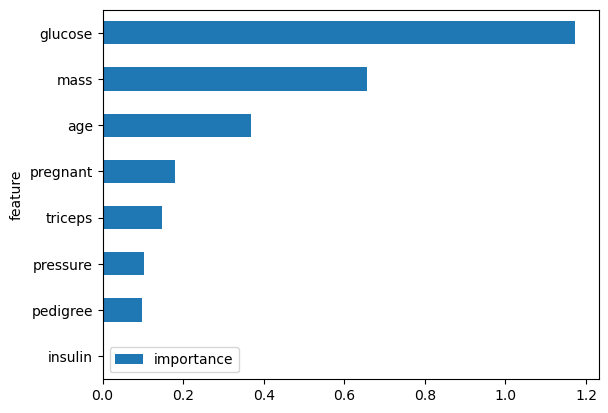

In [24]:
lasso_importance = pd.DataFrame()
lasso_importance["feature"] = X_train_scaled.columns
lasso_importance["importance"] = abs(lasso.coef_[0])
lasso_importance = lasso_importance.sort_values(by = ["importance"], ascending=True)

print(X_train_scaled.columns)
print(lasso.coef_[0])
print(lasso.intercept_)

ax = lasso_importance.plot.barh(x='feature', y='importance')
plt.show()

#### 4.3 Ridge

In [30]:
l2 = {'Model': LogisticRegression(),
       'cv_parm': {'penalty': ['l2'],
                   'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                   'solver': ['lbfgs'],
                   #'max_iter': [1000],
                   'random_state': [42]}}

grid_search_ridge = GridSearchCV(estimator = l2['Model'], param_grid = l2['cv_parm'], scoring = 'accuracy', cv =5)# ,  verbose=10)
grid_search_ridge.fit(X_train_scaled, y_train)
print(grid_search_ridge.best_estimator_)

LogisticRegression(C=1, random_state=42)


In [31]:
ridge = LogisticRegression(penalty='l2', solver='lbfgs', C=1, random_state=42)
ridge.fit(X_train_scaled, y_train)
y_pred_ridge = ridge.predict(X_test_scaled)

auc_ridge = float(format(roc_auc_score(y_test, y_pred_ridge), '.4f'))
cnfm_ridge = confusion_matrix(y_test, y_pred_ridge)
score_ridge = accuracy_score(y_test, y_pred_ridge)

print("The AUC for Ridge is {}".format(auc_ridge))
print("The confustion matrix for Ridge is {}".format(cnfm_ridge))
print("The accuracy for Ridge is {}".format(score_ridge))

The AUC for Ridge is 0.6977
The confustion matrix for Ridge is [[122  29]
 [ 33  47]]
The accuracy for Ridge is 0.7316017316017316


Index(['pregnant', 'glucose', 'pressure', 'triceps', 'insulin', 'mass',
       'pedigree', 'age'],
      dtype='object')
[ 0.1867943   1.18056026 -0.12115238  0.16047072 -0.01251349  0.66239918
  0.11190301  0.38343324]
    feature  importance
4   insulin    0.012513
6  pedigree    0.111903
2  pressure    0.121152
3   triceps    0.160471
0  pregnant    0.186794
7       age    0.383433
5      mass    0.662399
1   glucose    1.180560
[-0.89015312]


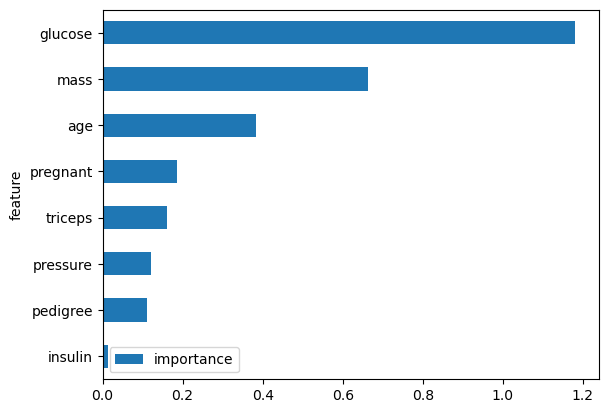

In [32]:
ridge_importance = pd.DataFrame()
ridge_importance["feature"] = X_train_scaled.columns
ridge_importance["importance"] = abs(ridge.coef_[0])
ridge_importance = ridge_importance.sort_values(by = ["importance"], ascending=True)

print(X_train_scaled.columns)
print(ridge.coef_[0])
print(ridge_importance)
print(ridge.intercept_)

ax = ridge_importance.plot.barh(x='feature', y='importance')
plt.show()

#### 4.4 Elastic-Net

In [33]:
l1l2 = {'Model': LogisticRegression(),
       'cv_parm': {'penalty': ['elasticnet'],
                   'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                   'l1_ratio': np.linspace(0.1,0.9,9),
                   'solver': ['saga'],
                   'max_iter': [1000],
                   'random_state': [42]}}

grid_search_elasticnet = GridSearchCV(estimator = l1l2['Model'], param_grid = l1l2['cv_parm'], scoring = 'roc_auc', cv =5)# ,  verbose=10)
grid_search_elasticnet.fit(X_train_scaled, y_train)
print(grid_search_elasticnet.best_estimator_)

LogisticRegression(C=0.1, l1_ratio=0.6, max_iter=1000, penalty='elasticnet',
                   random_state=42, solver='saga')


In [34]:
elasticnet = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.6, C=0.1, random_state=42, tol=1e-2)
elasticnet.fit(X_train_scaled, y_train)
y_pred_elasticnet = elasticnet.predict(X_test_scaled)
auc_elasticnet = float(format(roc_auc_score(y_test, y_pred_elasticnet), '.4f'))
cnfm_elasticnet = confusion_matrix(y_test, y_pred_elasticnet)
score_elasticnet = elasticnet.score(X_test_scaled, y_test)

print("The AUC for Elastic-Net is {}".format(auc_elasticnet))
print("The confustion matrix for Elastic-Net is {}".format(cnfm_elasticnet))
print("The accuracy for Elastic-Net is {}".format(score_elasticnet))

The AUC for Elastic-Net is 0.7077
The confustion matrix for Elastic-Net is [[125  26]
 [ 33  47]]
The accuracy for Elastic-Net is 0.7445887445887446


Index(['pregnant', 'glucose', 'pressure', 'triceps', 'insulin', 'mass',
       'pedigree', 'age'],
      dtype='object')
[1.25244050e-01 1.01572993e+00 0.00000000e+00 1.19955788e-01
 9.89992465e-04 5.41672922e-01 5.17372836e-02 3.00080000e-01]
    feature  importance
2  pressure    0.000000
4   insulin    0.000990
6  pedigree    0.051737
3   triceps    0.119956
0  pregnant    0.125244
7       age    0.300080
5      mass    0.541673
1   glucose    1.015730
[-0.83072975]


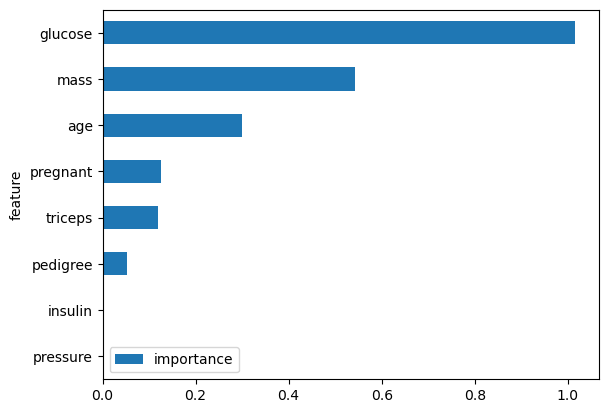

In [35]:
elasticnet_importance = pd.DataFrame()
elasticnet_importance["feature"] = X_train_scaled.columns
elasticnet_importance["importance"] = abs(elasticnet.coef_[0])
elasticnet_importance = elasticnet_importance.sort_values(by = ["importance"], ascending=True)

print(X_train_scaled.columns)
print(elasticnet.coef_[0])
print(elasticnet_importance)
print(elasticnet.intercept_)

ax = elasticnet_importance.plot.barh(x='feature', y='importance')
plt.show()